This notebook is about to test the futbin.csv data file with neural network models. This notebook is running in the Google colab environment to use the computational capacity of the cloud.
The dataset is the same futbin.csv but uploaded into Google drive.

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

In [2]:
!python -m pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
#from tensorflow_addons.metrics import RSquare
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
%matplotlib inline

In [4]:
print(tf.__version__)

2.17.0


Mount google drive

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
!ls -la "/content/drive/My Drive/"

ls: '/content/drive/My Drive/termékek_Hegyalja út': No such file or directory
total 4862
-rw------- 1 root root  416884 Apr  8  2024 'Ajánlólevél Tauseef visa HU.pdf'
-rw------- 1 root root    2722 Jul 17  2022  all.txt
drwx------ 2 root root    4096 Mar 14  2024  CoinbaseWalletBackups
drwx------ 2 root root    4096 Jan 14  2024 '!!! finance'
drwx------ 2 root root    4096 Oct 17  2019 'foci tippek'
drwx------ 2 root root    4096 Sep 29 19:39  főzés
-rw------- 1 root root      30 Jul 17  2022  GB.txt
drwx------ 2 root root    4096 Aug  1  2020  Hegyalja
-rw------- 1 root root     177 Jun 26  2023 'LJMU Timeline.gsheet'
drwx------ 2 root root    4096 Aug 27  2023 'Meet Recordings'
-rw------- 1 root root     177 Jul  7 11:51 'Névtelen táblázat (1).gsheet'
-rw------- 1 root root     177 Jul  7 13:13 'Névtelen táblázat.gsheet'
-rw------- 1 root root 1477507 Jan 11  2023  passport.pdf
-rw------- 1 root root 1284466 Oct  8  2022  passport.png
drwx------ 2 root root    4096 Jul 2

This notebook is used the following page as a source:
https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/


https://machinelearningmastery.com/regression-metrics-for-machine-learning/

https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/

https://machinelearningmastery.com/train-final-machine-learning-model/

https://pyimagesearch.com/2019/01/21/regression-with-keras/

**Part 1**: Import the futbin data and do feature transformations, scaling

In [7]:
df=pd.read_csv('/content/drive/My Drive/Upgrad/Thesis/3. Thesis/jupyter/futbin24.csv')
df.head()

,Name,Rating,Price,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,...,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
0,Erling Haaland,97,1980000.0,4,5,96.0,98,80,91,56,...,0,0,0,0,0,0,0,0,1,1
1,Kylian Mbappé,97,6250000.0,5,4,99.0,96,88,97,47,...,0,0,0,0,0,0,0,0,1,1
2,Lionel Messi,97,2830000.0,5,4,91.0,96,97,98,40,...,0,0,0,0,0,0,0,1,0,1
3,Pelé,97,6400000.0,5,5,95.0,96,92,96,60,...,0,0,0,0,0,0,0,0,1,1
4,Johan Cruyff,97,3550000.0,5,5,93.0,95,93,97,50,...,0,0,0,0,0,0,0,0,1,1


### Data segmentation

#### outlier handling

In [12]:
# Calculate Q1 and Q3
Q1 = np.percentile(df.Price, 25)
Q3 = np.percentile(df.Price, 75)
IQR = Q3 - Q1

# Determine the lower and upper bounds
lower_bound = Q1 - 20 * IQR
upper_bound = Q3 + 20 * IQR

# Find outliers
#outliers = df[(df.Price < lower_bound) | (df.Price > upper_bound)]

#Q1

#Q3

#outliers.info()

filtered_data = df[(df.Price >= lower_bound) & (df.Price <= upper_bound)]

filtered_data.Price.describe()

,Price
count,8405.000000
mean,6531.148126
std,14875.060627
min,200.000000
25%,200.000000
50%,400.000000
75%,1400.000000
max,90500.000000


#### data segmetation based on gender and position

In [13]:
##### male-female split

male_players = filtered_data[filtered_data.Gender_Male == 1]

female_players = filtered_data[filtered_data.Gender_Male == 0]

#male_players.info()

#female_players.info()

##### goalkeepers

maleGK = male_players[male_players.Main_Position_GK == 1]

#maleGK.info()

#maleGK.head()

#maleGK.Price.describe()

#maleGK.shape

#femaleGK.shape





femaleGK = female_players[female_players.Main_Position_GK == 1]

#femaleGK.info()

#femaleGK.head()

##### defenders

maleD = male_players[(male_players.Main_Position_CB == 1)
                     | (male_players.Main_Position_LB == 1)
                     | (male_players.Main_Position_LWB == 1)
                     | (male_players.Main_Position_RB == 1)
                     | (male_players.Main_Position_RWB == 1)]

#maleD.info()

#maleD.head()

femaleD = female_players[(female_players.Main_Position_CB == 1)
                     | (female_players.Main_Position_LB == 1)
                     | (female_players.Main_Position_LWB == 1)
                     | (female_players.Main_Position_RB == 1)
                     | (female_players.Main_Position_RWB == 1)]

#femaleD.info()

#femaleD.head()

##### midfielders

maleM = male_players[(male_players.Main_Position_CDM == 1)
                     | (male_players.Main_Position_CM == 1)
                     | (male_players.Main_Position_LM == 1)
                     | (male_players.Main_Position_LW == 1)
                     | (male_players.Main_Position_RM == 1)
                     | (male_players.Main_Position_RW == 1)
                     | (
                         (male_players.Main_Position_CB == 0)
                         & (male_players.Main_Position_LB == 0)
                         & (male_players.Main_Position_LWB == 0)
                         & (male_players.Main_Position_RB == 0)
                         & (male_players.Main_Position_RWB == 0)
                         & (male_players.Main_Position_GK == 0)
                         & (male_players.Main_Position_CF == 0)
                         & (male_players.Main_Position_ST == 0)
                         & (male_players.Main_Position_CDM == 0)
                         & (male_players.Main_Position_CM == 0)
                         & (male_players.Main_Position_LM == 0)
                         & (male_players.Main_Position_LW == 0)
                         & (male_players.Main_Position_RM == 0)
                         & (male_players.Main_Position_RW == 0)
                       )]

#maleM.info()

#maleM.head()

femaleM = female_players[(female_players.Main_Position_CDM == 1)
                     | (female_players.Main_Position_CM == 1)
                     | (female_players.Main_Position_LM == 1)
                     | (female_players.Main_Position_LW == 1)
                     | (female_players.Main_Position_RM == 1)
                     | (female_players.Main_Position_RW == 1)
                     | (
                         (female_players.Main_Position_CB == 0)
                         & (female_players.Main_Position_LB == 0)
                         & (female_players.Main_Position_LWB == 0)
                         & (female_players.Main_Position_RB == 0)
                         & (female_players.Main_Position_RWB == 0)
                         & (female_players.Main_Position_GK == 0)
                         & (female_players.Main_Position_CF == 0)
                         & (female_players.Main_Position_ST == 0)
                         & (female_players.Main_Position_CDM == 0)
                         & (female_players.Main_Position_CM == 0)
                         & (female_players.Main_Position_LM == 0)
                         & (female_players.Main_Position_LW == 0)
                         & (female_players.Main_Position_RM == 0)
                         & (female_players.Main_Position_RW == 0)
                       )]

#femaleM.info()

#femaleM.head()

##### Forwarders

maleF = male_players[(male_players.Main_Position_CF == 1)
                     | (male_players.Main_Position_ST == 1)]

#maleF.info()

#maleF.head()

femaleF = female_players[(female_players.Main_Position_CF == 1)
                     | (female_players.Main_Position_ST == 1)]

#femaleF.info()

##### check the numbers to make sure that there are no mising players from the segmented datasets

#all checks should be True

#len(filtered_data) == len(male_players) + len(female_players)

#len(male_players) == len(maleGK) + len(maleD) + len(maleM) + len(maleF)

#len(female_players) == len(femaleGK) + len(femaleD) + len(femaleM) + len(femaleF)

#len(maleM)







### FUT 23 experiments

In [11]:
X = maleGK.copy()
# Remove names
names = X.pop('Name')
# Remove target
Y = X.pop('Price')

# perform a scaler transform of the input data
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

# perform log transformation of target variable
#Y = np.log(Y)

In [11]:
#df_scaled = pd.DataFrame(X)
#df_scaled.head(2)
X.head(2)

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,...,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing,Gender_Male
52,95,3,3,96.0,91,88,95,72,92,-13,...,0,0,0,0,0,0,0,0,1,1
59,95,3,4,93.0,95,90,97,76,94,50,...,0,0,0,0,0,0,0,0,1,1


In [12]:
Y

,Price
52,49000.0
59,47000.0
95,69000.0
104,44000.0
125,64650.0
...,...
7680,200.0
7681,200.0
7683,200.0
7687,200.0


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.1, random_state=42)

**Part 2**: Create Model Using keras

First simple model, it has an input layer, one middle layer and one output layer.

In [21]:
# define base model
def baseline_model():
  model = keras.Sequential([
      keras.layers.Input(shape=(113,)),
      keras.layers.Dense(64, activation=tf.nn.relu),
      keras.layers.Dense(1, kernel_initializer='normal')])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='mean_absolute_error',
              metrics=['accuracy'])
  return model

In [17]:
%%time
estimator = KerasRegressor(model=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
print("Baseline: %.2f (%.2f) MAE" % (results.mean(), results.std()))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Baseline: -1479.29 (3206.40) MAE
CPU times: user 11min 37s, sys: 34.4 s, total: 12min 11s
Wall time: 11min 58s


In [18]:
results

array([-11083.43465078,   -673.43701471,   -277.52001812,   -151.81929095,
         -238.77953378,   -437.96241831,   -494.04564078,   -295.13939022,
         -388.16866101,   -752.5922616 ])

The second model is a deeper structure, it has more middle layers.

In [19]:
# define deeper model
def deeper_model():
  model = keras.Sequential([
    keras.layers.Input(shape=(113,)),
    keras.layers.Dense(96, activation=tf.nn.relu),
    keras.layers.Dense(82, activation=tf.nn.relu),
    keras.layers.Dense(68, activation=tf.nn.relu),
    keras.layers.Dense(42, activation=tf.nn.relu),
    keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(22, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.relu),
    keras.layers.Dense(1, kernel_initializer='normal')])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
             loss='mean_absolute_error',
              metrics=['accuracy'])
  return model

In [20]:
%%time
estimator2 = KerasRegressor(model=deeper_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator2, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
print("Deeperline: %.2f (%.2f) MAE" % (results.mean(), results.std()))

Deeperline: -1471.52 (3184.16) MAE
CPU times: user 19min 3s, sys: 40.9 s, total: 19min 44s
Wall time: 20min 17s


The third model is a wider model, the input layer is wider than the input size.

In [22]:
# define wider model
def wider_model():
  model = keras.Sequential([
    keras.layers.Dense(256, activation=tf.nn.relu, input_shape=(113,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(1, kernel_initializer='normal')])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
             loss='mean_absolute_error',
              metrics=['accuracy'])
  return model

In [23]:
%%time
estimator3 = KerasRegressor(model=wider_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator3, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
print("Widerline: %.2f (%.2f) MAE" % (results.mean(), results.std()))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Widerline: -1471.44 (3183.96) MAE
CPU times: user 17min 49s, sys: 37.5 s, total: 18min 26s
Wall time: 18min 53s


Deeper model with standardized step

In [24]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=deeper_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)

In [25]:
%%time
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
print("Standardized deeper: %.2f (%.2f) MAE" % (results.mean(), results.std()))

Standardized deeper: -1471.50 (3184.15) MAE
CPU times: user 19min 23s, sys: 40.8 s, total: 20min 4s
Wall time: 20min 58s


In [ ]:
estimators2 = []
estimators2.append(('standardize', StandardScaler()))
estimators2.append(('mlp', KerasRegressor(model=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline2 = Pipeline(estimators2)

In [ ]:
%%time
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline2, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
print("Standardized wider: %.2f (%.2f) MAE" % (results.mean(), results.std()))

Standardized wider: -25354.22 (73549.22) MAE
CPU times: user 1h 6min 50s, sys: 2min 10s, total: 1h 9min
Wall time: 1h 2min 6s


Final model validation
The deeper model is the best, predict y with it

In [26]:
# define final model
def final_model():
  model = keras.Sequential([
    keras.layers.Input(shape=(113,)),
    keras.layers.Dense(96, activation=tf.nn.relu),
    keras.layers.Dense(82, activation=tf.nn.relu),
    keras.layers.Dense(68, activation=tf.nn.relu),
    keras.layers.Dense(42, activation=tf.nn.relu),
    keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(22, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.relu),
    keras.layers.Dense(1, activation="linear", kernel_initializer='normal')])

  opt = Adam(learning_rate=1e-3)
  model.compile(optimizer=opt,
             loss='mean_absolute_percentage_error')
  return model

In [27]:
final_model = final_model()

In [28]:
from keras.utils import plot_model

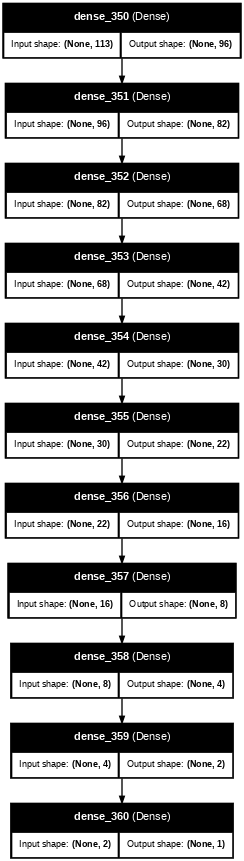

In [29]:
keras.utils.plot_model(final_model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=48)

In [30]:
pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.5 MB/s eta 0:00:00


In [31]:
import visualkeras

In [32]:
visualkeras.layered_view(final_model).show()

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [33]:
final_model.fit(x=X_train, y=y_train,
	validation_data=(X_val, y_val),
	epochs=500, batch_size=20)

Epoch 1/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 99.9919 - val_loss: 99.9655
Epoch 2/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.9599 - val_loss: 99.9311
Epoch 3/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 99.9274 - val_loss: 99.8969
Epoch 4/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 99.8968 - val_loss: 99.8628
Epoch 5/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.8613 - val_loss: 99.8285
Epoch 6/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99.8319 - val_loss: 99.7943
Epoch 7/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99.7969 - val_loss: 99.7600
Epoch 8/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.7674 - val_loss: 99.7259
Epoch 9/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.7344 - val_loss: 99.6918
Epoch 10/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 99.6995 - val_loss: 99.6575
Epoch 11/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.6681 - val_loss: 99.6235
Epoch 12/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0

In [34]:
preds = final_model.predict(X_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [35]:
diff = preds.flatten() - y_val
percentDiff = (diff / y_val) * 100
absPercentDiff = np.abs(percentDiff)

In [36]:
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

In [1]:
print("[INFO] avg. player price: {}, std player price: {}".format(
	df["Price"].mean(), df["Price"].std()))

NameError: name 'df' is not defined

In [38]:
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] mean: 82.94%, std: 6.80%


In [27]:
def nn(data):
  X = data.copy()
  # Remove names
  names = X.pop('Name')
  # Remove target
  y = X.pop('Price')
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=42)

  model = keras.Sequential([
    keras.layers.Input(shape=(113,)),
    keras.layers.Dense(96, activation=tf.nn.relu),
    keras.layers.Dense(82, activation=tf.nn.relu),
    keras.layers.Dense(68, activation=tf.nn.relu),
    keras.layers.Dense(42, activation=tf.nn.relu),
    keras.layers.Dense(30, activation=tf.nn.relu),
    keras.layers.Dense(22, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(8, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.relu),
    keras.layers.Dense(1, activation="linear", kernel_initializer='normal')])

  opt = Adam(learning_rate=1e-3)
  model.compile(optimizer=opt, loss='mean_absolute_percentage_error')

  model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=20)

  preds = model.predict(X_val)
  diff = preds.flatten() - y_val
  percentDiff = (diff / y_val) * 100
  absPercentDiff = np.abs(percentDiff)
  mean = np.mean(absPercentDiff)
  std = np.std(absPercentDiff)
  print("[INFO] original avg. player price: {}, std player price: {}".format(data["Price"].mean(), data["Price"].std()))
  print("[INFO] results mean: {:.2f}%, std: {:.2f}%".format(mean, std))

**maleGK**

In [15]:
nn(maleGK)

Epoch 1/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 100.0139 - val_loss: 99.9652
Epoch 2/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 99.9590 - val_loss: 99.9310
Epoch 3/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.9269 - val_loss: 99.8968
Epoch 4/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 99.8922 - val_loss: 99.8626
Epoch 5/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99.8630 - val_loss: 99.8287
Epoch 6/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.8286 - val_loss: 99.7944
Epoch 7/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.7968 - val_loss: 99.7604
Epoch 8/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.7629 - val_loss: 99.7262
Epoch 9/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99.7309 - val_loss: 99.6921
Epoch 10/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 99.7006 - val_loss: 99.6582
Epoch 11/1000
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 99.6728 - val_loss: 99.6242
Epoch 12/1000
88/88 ━━━━━━━━━

### new nn version with keras for EA FC 24

In [27]:
def nn2(data):
  # Load and prepare your data
  X = data.copy()
  # Remove names
  names = X.pop('Name')
  # Remove target
  y = X.pop('Price')

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Standardize the feature values for better model performance
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Define the model architecture
  model = keras.Sequential([
      keras.layers.Input(shape=(113,)),
      keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.LeakyReLU(negative_slope=0.1),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.LeakyReLU(negative_slope=0.1),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.LeakyReLU(negative_slope=0.1),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.LeakyReLU(negative_slope=0.1),
      keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.LeakyReLU(negative_slope=0.1),
      keras.layers.Dense(16, activation="relu"),
      keras.layers.LeakyReLU(negative_slope=0.1),
      keras.layers.Dense(1)  # Output layer with 1 neuron for regression
      ])
  # Compile the model with a suitable optimizer and loss for regression
  model.compile(optimizer="adam", loss="mse", metrics=["mae"])

  # Train the model
  history = model.fit(
      X_train, y_train,
      epochs=200,
      batch_size=32,
      validation_split=0.2,  # Use 20% of training data as validation set
      verbose=1
      )

  # Evaluate the model on the test data
  test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
  print(f"Test Loss: {test_loss}")
  print(f"Test Mean Absolute Error: {test_mae}")

  # Predict prices on the test set
  predictions = model.predict(X_test)
  mape = mean_absolute_percentage_error(y_test, predictions)
  print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

  # Display predictions vs actual prices
  plt.scatter(y_test, predictions)
  plt.xlabel("Actual Prices")
  plt.ylabel("Predicted Prices")
  plt.title("Actual vs Predicted Prices")
  plt.show()

Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 28931302.0000 - mae: 1523.9181 - val_loss: 16248347.0000 - val_mae: 1054.5460
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28507330.0000 - mae: 1494.9346 - val_loss: 15703635.0000 - val_mae: 1023.1142
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21253354.0000 - mae: 1290.1145 - val_loss: 11661858.0000 - val_mae: 867.1038
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23019164.0000 - mae: 1451.3613 - val_loss: 7201600.0000 - val_mae: 993.5503
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 15179217.0000 - mae: 1506.6478 - val_loss: 7490966.0000 - val_mae: 1241.8284
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16312069.0000 - mae: 1568.1357 - val_loss: 9733456.0000 - val_mae: 1232.0680
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13976137.0000 - mae: 1531.3568 - val_loss: 11168924.0000 - val_mae: 1066.2646
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1

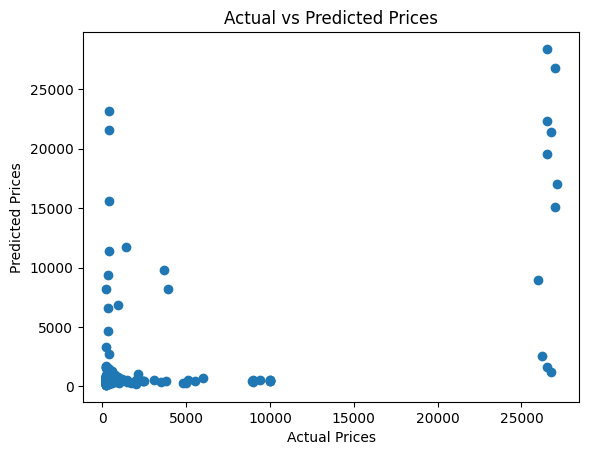

CPU times: user 2min, sys: 6.6 s, total: 2min 7s
Wall time: 2min 7s


In [39]:
%%time
nn2(maleGK)

Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 141097328.0000 - mae: 3789.5159 - val_loss: 168652672.0000 - val_mae: 4131.7139
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 143855184.0000 - mae: 3830.0273 - val_loss: 144317504.0000 - val_mae: 3796.7354
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 167972544.0000 - mae: 4368.9409 - val_loss: 59238152.0000 - val_mae: 2453.1184
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 78302240.0000 - mae: 3056.7419 - val_loss: 70939704.0000 - val_mae: 3421.9849
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 86844576.0000 - mae: 3496.0676 - val_loss: 40067416.0000 - val_mae: 2451.4785
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 48689272.0000 - mae: 2566.9673 - val_loss: 37980348.0000 - val_mae: 1961.7920
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 47621584.0000 - mae: 2636.7954 - val_loss: 39653444.0000 - val_mae: 2072.9795
Epoch 8/200
56/56 ━━━━━━━━━━━━━━━

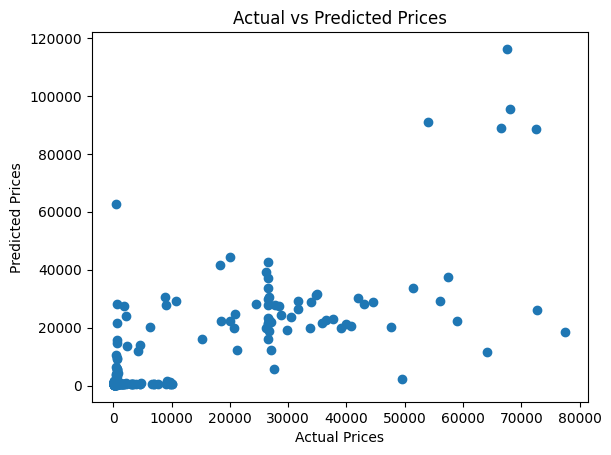

CPU times: user 2min 43s, sys: 9.04 s, total: 2min 52s
Wall time: 2min 35s


In [29]:
%%time
nn2(maleD)

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 431197728.0000 - mae: 10295.0195 - val_loss: 369495648.0000 - val_mae: 9142.0840
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 447037152.0000 - mae: 9994.5322 - val_loss: 334203392.0000 - val_mae: 8613.6875
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 468484672.0000 - mae: 10582.9463 - val_loss: 191118000.0000 - val_mae: 6496.2515
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 228977840.0000 - mae: 6615.7183 - val_loss: 92680640.0000 - val_mae: 4390.3340
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 107300336.0000 - mae: 4660.0981 - val_loss: 106049864.0000 - val_mae: 4754.0308
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 110216864.0000 - mae: 4891.9473 - val_loss: 93334344.0000 - val_mae: 4411.4468
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 75847752.0000 - mae: 4159.9424 - val_loss: 96650360.0000 - val_mae: 4475.3638
Epoch 8/200
40/40 ━━━━━━

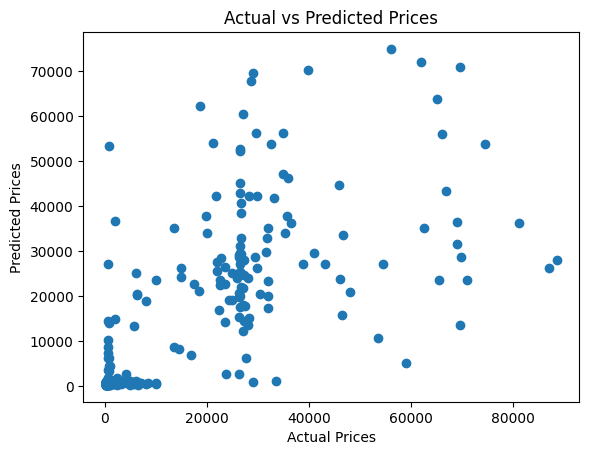

CPU times: user 2min 5s, sys: 6.89 s, total: 2min 12s
Wall time: 2min 16s


In [30]:
%%time
nn2(maleM)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 977827712.0000 - mae: 22941.4941 - val_loss: 836791488.0000 - val_mae: 19465.5000
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 940906944.0000 - mae: 22261.5195 - val_loss: 836782336.0000 - val_mae: 19465.3223
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 926582720.0000 - mae: 21314.6328 - val_loss: 836748800.0000 - val_mae: 19464.8496
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 953834816.0000 - mae: 21985.3730 - val_loss: 836637440.0000 - val_mae: 19463.4121
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 983762048.0000 - mae: 22543.3379 - val_loss: 836281920.0000 - val_mae: 19458.9961
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 961712896.0000 - mae: 22114.2031 - val_loss: 835246912.0000 - val_mae: 19446.4805
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 928197184.0000 - mae: 21836.5234 - val_loss: 833024960.0000 - val_mae: 19419.0469
Epoch 

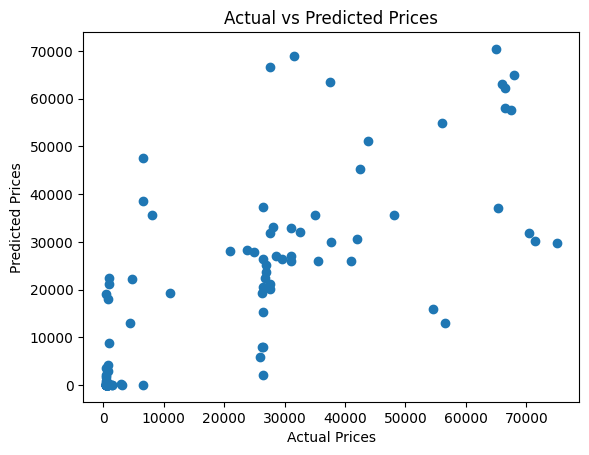

CPU times: user 50.5 s, sys: 2.35 s, total: 52.9 s
Wall time: 1min


In [31]:
%%time
nn2(maleF)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 56654624.0000 - mae: 2637.4473 - val_loss: 40531000.0000 - val_mae: 2153.3135
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 42553700.0000 - mae: 2076.2085 - val_loss: 40529384.0000 - val_mae: 2153.2261
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 53041636.0000 - mae: 2170.8882 - val_loss: 40526648.0000 - val_mae: 2153.0969
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 52758492.0000 - mae: 2291.0684 - val_loss: 40522168.0000 - val_mae: 2152.9038
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 46490372.0000 - mae: 2209.5935 - val_loss: 40515956.0000 - val_mae: 2152.6392
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 59343916.0000 - mae: 2256.8401 - val_loss: 40505212.0000 - val_mae: 2152.2388
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 50548044.0000 - mae: 2177.2056 - val_loss: 40488328.0000 - val_mae: 2151.6753
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/st

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Mean Absolute Percentage Error (MAPE): 147.44%


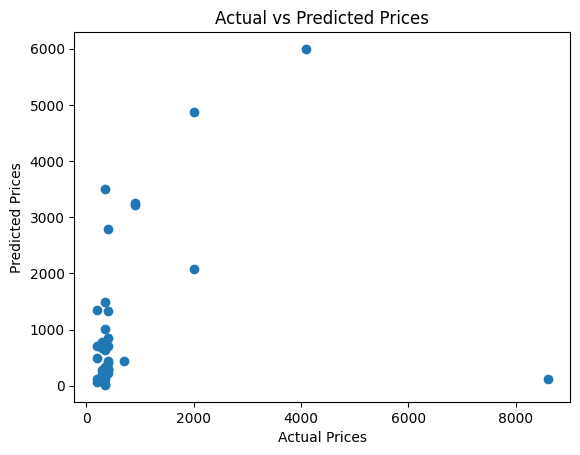

CPU times: user 27.2 s, sys: 1.1 s, total: 28.3 s
Wall time: 32.4 s


In [32]:
%%time
nn2(femaleGK)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 131065464.0000 - mae: 4247.9077 - val_loss: 109982968.0000 - val_mae: 4286.8735
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 134572608.0000 - mae: 4223.3164 - val_loss: 109972304.0000 - val_mae: 4286.2954
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 133563768.0000 - mae: 4127.6606 - val_loss: 109943016.0000 - val_mae: 4285.0039
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 140568768.0000 - mae: 4162.2896 - val_loss: 109864240.0000 - val_mae: 4282.1611
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 122280952.0000 - mae: 3903.0281 - val_loss: 109664920.0000 - val_mae: 4275.8408
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 147443664.0000 - mae: 4507.4658 - val_loss: 109140136.0000 - val_mae: 4261.7622
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 152843760.0000 - mae: 4330.0859 - val_loss: 108079064.0000 - val_mae: 4235.6060
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━

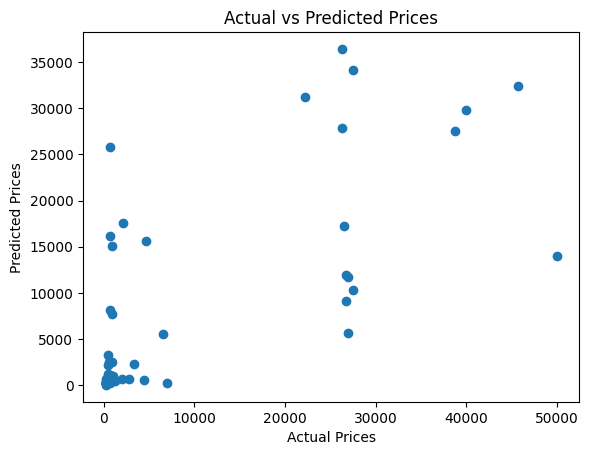

CPU times: user 39.2 s, sys: 1.89 s, total: 41.1 s
Wall time: 44.7 s


In [33]:
%%time
nn2(femaleD)

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 233079936.0000 - mae: 6922.4360 - val_loss: 252748912.0000 - val_mae: 7626.9692
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 252039792.0000 - mae: 7316.2183 - val_loss: 252713648.0000 - val_mae: 7626.1011
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 284477216.0000 - mae: 7370.6387 - val_loss: 252549712.0000 - val_mae: 7622.5176
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 319341728.0000 - mae: 7520.4976 - val_loss: 251910240.0000 - val_mae: 7609.4639
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 280370528.0000 - mae: 7849.1914 - val_loss: 249871664.0000 - val_mae: 7568.3882
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 294001984.0000 - mae: 7370.6304 - val_loss: 245998192.0000 - val_mae: 7492.1709
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 266786688.0000 - mae: 7520.1543 - val_loss: 238877952.0000 - val_mae: 7351.9341
Epoch 8/200
11/11 ━━

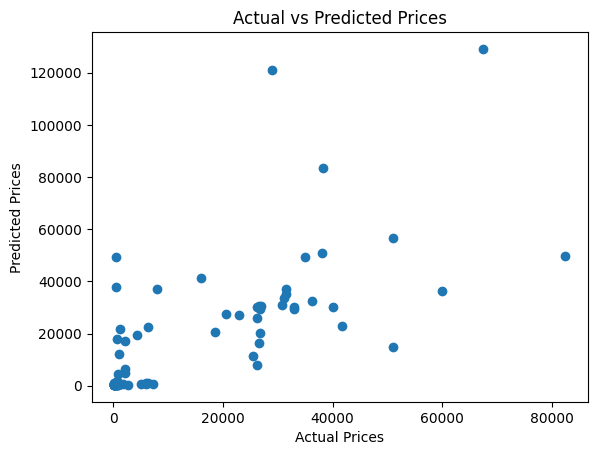

CPU times: user 48.1 s, sys: 2.43 s, total: 50.5 s
Wall time: 56.1 s


In [34]:
%%time
nn2(femaleM)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - loss: 505264640.0000 - mae: 12508.3945 - val_loss: 266923088.0000 - val_mae: 9861.8525
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 500911936.0000 - mae: 12579.0781 - val_loss: 266921472.0000 - val_mae: 9861.8184
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 640973184.0000 - mae: 14541.5205 - val_loss: 266918816.0000 - val_mae: 9861.7607
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 608098304.0000 - mae: 13855.3457 - val_loss: 266914912.0000 - val_mae: 9861.6768
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 573232704.0000 - mae: 13451.9971 - val_loss: 266907568.0000 - val_mae: 9861.5273
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 547858688.0000 - mae: 13002.1855 - val_loss: 266895536.0000 - val_mae: 9861.2832
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 569145600.0000 - mae: 13333.2617 - val_loss: 266877472.0000 - val_mae: 9860.9287
Epoch 8/200
3/3 ━━━━━━━━━━

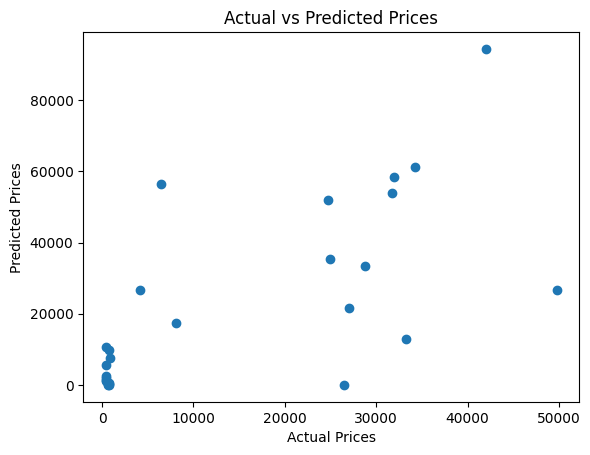

CPU times: user 26.2 s, sys: 1.19 s, total: 27.4 s
Wall time: 31.3 s


In [35]:
%%time
nn2(femaleF)

### latest models with XGBoost

In [16]:
def xgboost(data):
  # Load and prepare your data
  X = data.copy()
  # Remove names
  names = X.pop('Name')
  # Remove target
  y = X.pop('Price')

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  param_grid = {
      'n_estimators': [100, 200, 300],
      'learning_rate': [0.01, 0.1, 0.2],
      'max_depth': [3, 6, 9],
      'subsample': [0.6, 0.8, 1.0]
      }

  # Define the XGBoost regressor model with GridSearchCV
  grid_search = GridSearchCV(
      estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
      param_grid=param_grid,
      scoring='neg_mean_squared_error',
      cv=3,
      verbose=1
      )

  # Fit the grid search to the data
  grid_search.fit(X_train, y_train)

  # Best parameters found by GridSearchCV
  best_params = grid_search.best_params_
  print("Best Parameters:", best_params)

  # Evaluate the best model
  best_model = grid_search.best_estimator_
  y_pred_best = best_model.predict(X_test)
  mse_best = mean_squared_error(y_test, y_pred_best)
  r2_best = r2_score(y_test, y_pred_best)
  mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
  print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2%}")
  mae = mean_absolute_error(y_test, y_pred_best)
  print(f"MAE: {mae}")
  print(f"Mean Squared Error: {mse_best}")
  rmse = root_mean_squared_error(y_test, y_pred_best)  # RMSE
  print(f"RMSE: {rmse}")
  print(f"R-squared: {r2_best}")

In [14]:
%%time
xgboost(maleGK)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 196.18%
MAE: 1060.503649254486
Mean Squared Error: 6052735.930258758
RMSE: 2460.230869300432
R-squared: 0.7344829320058552
CPU times: user 4min 4s, sys: 1.81 s, total: 4min 6s
Wall time: 2min 37s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
%%time
xgboost(maleD)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 208.77%
MAE: 2169.569222393346
Mean Squared Error: 28057413.761706788
RMSE: 5296.9249344980135
R-squared: 0.8180025682898007
CPU times: user 4min 58s, sys: 2.15 s, total: 5min
Wall time: 3min 6s


In [19]:
%%time
xgboost(maleM)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 237.85%
MAE: 4498.235218776092
Mean Squared Error: 81528829.88800657
RMSE: 9029.33164126817
R-squared: 0.7492916618786547
CPU times: user 4min 51s, sys: 1.99 s, total: 4min 53s
Wall time: 3min 2s


In [20]:
xgboost(maleF)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.8}
Mean Absolute Percentage Error (MAPE): 344.73%
MAE: 8270.520225600441
Mean Squared Error: 186440026.59489903
RMSE: 13654.304324823694
R-squared: 0.6285174513397287


In [21]:
xgboost(femaleGK)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 69.59%
MAE: 629.5653432210287
Mean Squared Error: 2529791.406885477
RMSE: 1590.5318000233372
R-squared: -0.12345405191447756


In [22]:
xgboost(femaleD)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 148.66%
MAE: 2469.397956944719
Mean Squared Error: 25785818.75113537
RMSE: 5077.973882478657
R-squared: 0.8255208923483357


In [23]:
%%time
xgboost(femaleM)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Mean Absolute Percentage Error (MAPE): 186.82%
MAE: 4589.789619231892
Mean Squared Error: 85726101.82643662
RMSE: 9258.839118725231
R-squared: 0.7065239975900186
CPU times: user 3min 11s, sys: 1.65 s, total: 3min 13s
Wall time: 2min 1s


In [24]:
%%time
xgboost(femaleF)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 437.55%
MAE: 6859.9672114054365
Mean Squared Error: 117537523.95010526
RMSE: 10841.472406924499
R-squared: 0.5326489459514056
CPU times: user 2min 13s, sys: 1.5 s, total: 2min 14s
Wall time: 1min 27s


### xgboost, without category columns

In [80]:
maleGKnarrow = maleGK.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,114]]

In [81]:
maleGKnarrow.head()

,Name,Rating,Price,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Gender_Male
737,Ederson,88,10250.0,1,3,86.0,82,91,86,64,86,239,495,1227,188,86,0,0,0,1
742,Jan Oblak,88,10000.0,1,3,85.0,90,78,87,46,86,210,472,1035,188,87,0,0,0,1
977,Gregor Kobel,87,7800.0,1,3,86.0,84,74,89,44,85,334,462,920,195,88,0,0,0,1
980,Gianluigi Donnarumma,87,7800.0,1,3,90.0,82,79,89,52,83,203,475,1012,196,90,0,0,0,1
982,Mike Maignan,87,8100.0,1,4,85.0,82,87,89,51,85,417,479,1160,191,89,0,0,0,1


In [82]:
%%time
xgboost(maleGKnarrow)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 150.13%
Mean Squared Error: 1926893.4778245098
R-squared: 0.0065986882759460075
CPU times: user 2min 23s, sys: 1.47 s, total: 2min 24s
Wall time: 1min 27s


### XGBoost for *Rating* stat prediction

In [25]:
def xgboost_rating(data):
  # Load and prepare your data
  X = data.copy()
  # Remove names
  names = X.pop('Name')
  # Remove target
  y = X.pop('Rating')

  # Split data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  param_grid = {
      'n_estimators': [100, 200, 300],
      'learning_rate': [0.01, 0.1, 0.2],
      'max_depth': [3, 6, 9],
      'subsample': [0.6, 0.8, 1.0]
      }

  # Define the XGBoost regressor model with GridSearchCV
  grid_search = GridSearchCV(
      estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
      param_grid=param_grid,
      scoring='neg_mean_squared_error',
      cv=3,
      verbose=1
      )

  # Fit the grid search to the data
  grid_search.fit(X_train, y_train)

  # Best parameters found by GridSearchCV
  best_params = grid_search.best_params_
  print("Best Parameters:", best_params)

  # Evaluate the best model
  best_model = grid_search.best_estimator_
  y_pred_best = best_model.predict(X_test)

  # Plotting y_test and y_pred to understand the spread
  fig = plt.figure()
  plt.scatter(y_test, y_pred_best)
  fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading
  plt.xlabel('y_test', fontsize = 18)                              # X-label
  plt.ylabel('y_pred', fontsize = 16)

  mse_best = mean_squared_error(y_test, y_pred_best)
  r2_best = r2_score(y_test, y_pred_best)
  mape_best = mean_absolute_percentage_error(y_test, y_pred_best)
  print(f"Mean Absolute Percentage Error (MAPE): {mape_best:.2%}")
  mae = mean_absolute_error(y_test, y_pred_best)
  print(f"MAE: {mae}")
  print(f"Mean Squared Error: {mse_best}")
  rmse = root_mean_squared_error(y_test, y_pred_best)  # RMSE
  print(f"RMSE: {rmse}")
  print(f"R-squared: {r2_best}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 0.92%
MAE: 0.5861741295156553
Mean Squared Error: 0.521395844949147
RMSE: 0.7220774507967598
R-squared: 0.9916839003562927
CPU times: user 4min 46s, sys: 1.89 s, total: 4min 47s
Wall time: 2min 57s


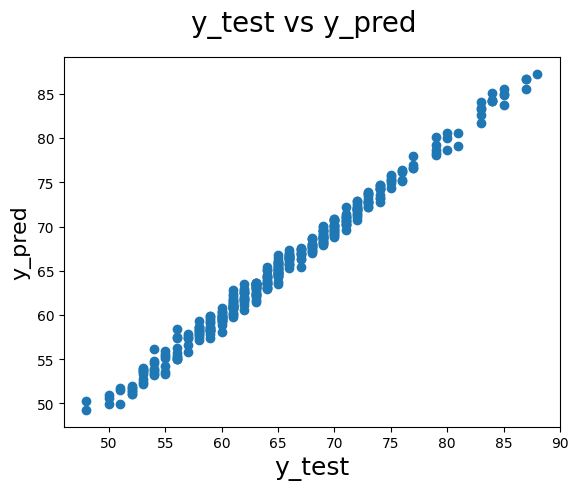

In [26]:
%%time
xgboost_rating(maleGK)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 0.86%
MAE: 0.5988836581625084
Mean Squared Error: 0.5596050217487807
RMSE: 0.7480675248590736
R-squared: 0.99271160364151
CPU times: user 5min 53s, sys: 2.16 s, total: 5min 56s
Wall time: 3min 37s


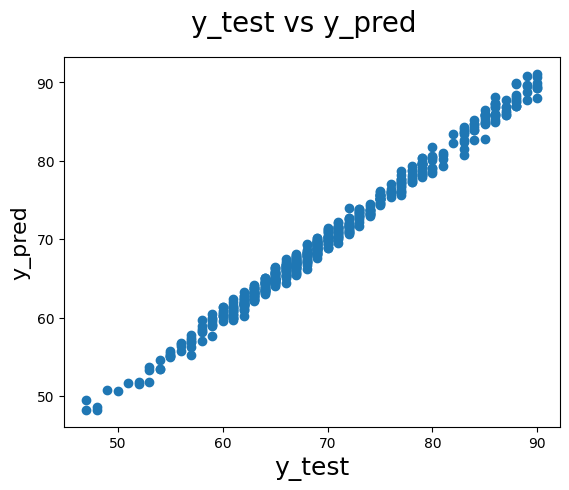

In [27]:
%%time
xgboost_rating(maleD)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 1.21%
MAE: 0.8554592860564021
Mean Squared Error: 1.1981452589915842
RMSE: 1.0945982180652334
R-squared: 0.9907341003417969
CPU times: user 5min 24s, sys: 2.06 s, total: 5min 26s
Wall time: 3min 18s


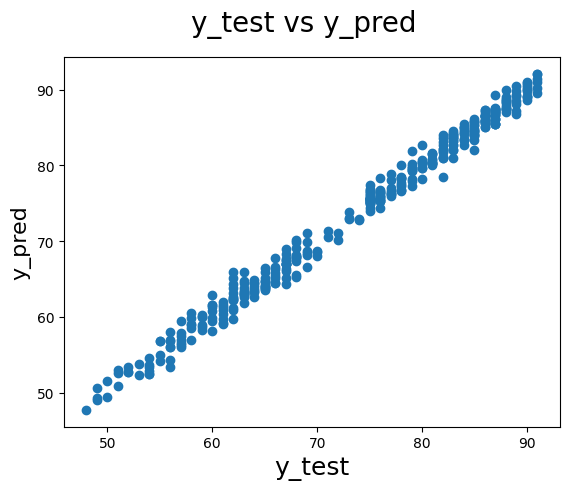

In [28]:
%%time
xgboost_rating(maleM)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 1.09%
MAE: 0.9048949137772664
Mean Squared Error: 1.4556605347707674
RMSE: 1.2065075775853078
R-squared: 0.9582955837249756
CPU times: user 3min 23s, sys: 1.6 s, total: 3min 25s
Wall time: 2min 9s


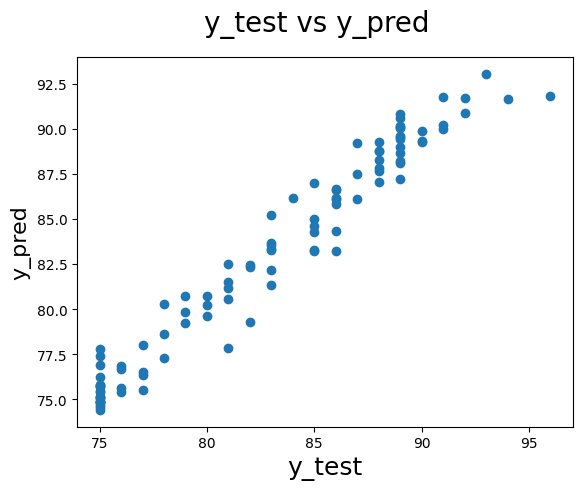

In [29]:
%%time
xgboost_rating(maleF)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 0.78%
MAE: 0.5807802412245009
Mean Squared Error: 0.4778663451029893
RMSE: 0.6912787752441046
R-squared: 0.9827277064323425
CPU times: user 2min 8s, sys: 1.35 s, total: 2min 10s
Wall time: 1min 23s


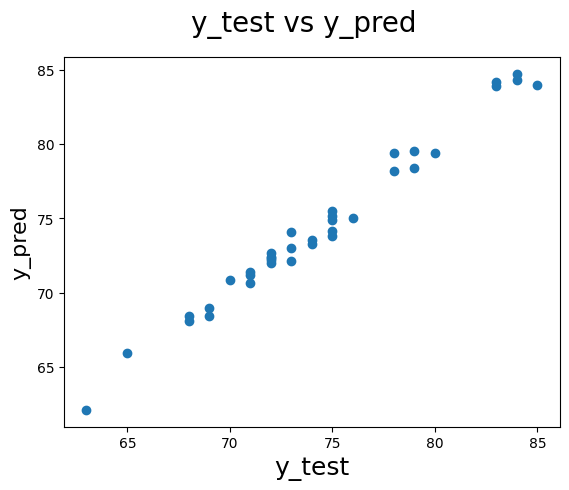

In [30]:
%%time
xgboost_rating(femaleGK)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 1.05%
MAE: 0.8242270071295243
Mean Squared Error: 1.1131597229552563
RMSE: 1.0550638478098169
R-squared: 0.9805984497070312
CPU times: user 2min 51s, sys: 1.63 s, total: 2min 53s
Wall time: 1min 50s


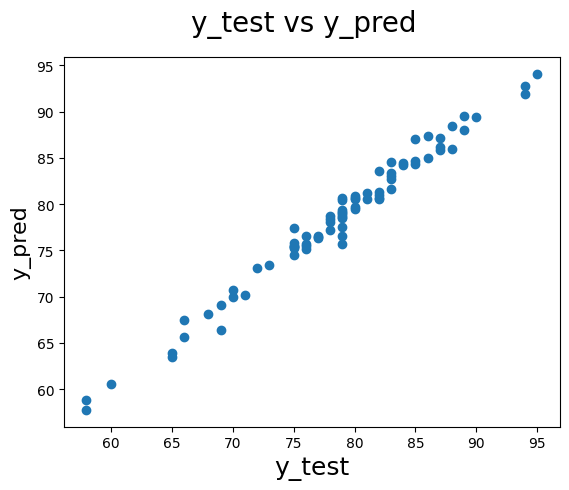

In [31]:
%%time
xgboost_rating(femaleD)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 1.48%
MAE: 1.1520027089341778
Mean Squared Error: 2.5550481526115276
RMSE: 1.5984517986512847
R-squared: 0.9658282399177551
CPU times: user 3min 21s, sys: 1.73 s, total: 3min 23s
Wall time: 2min 8s


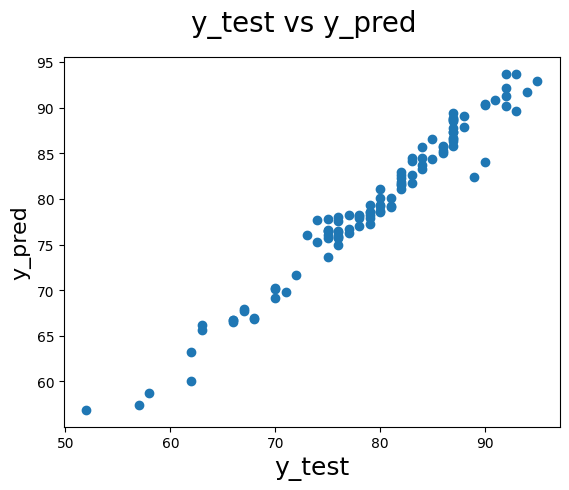

In [32]:
%%time
xgboost_rating(femaleM)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 0.91%
MAE: 0.7610001740632234
Mean Squared Error: 0.8174874237975692
RMSE: 0.9041501113186733
R-squared: 0.9709576964378357
CPU times: user 2min 7s, sys: 1.47 s, total: 2min 9s
Wall time: 1min 23s


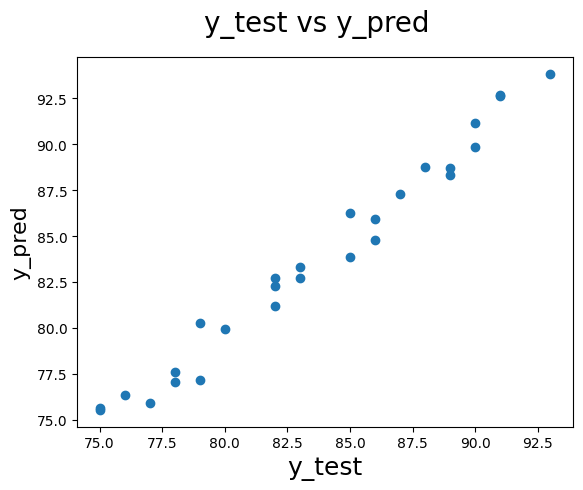

In [33]:
%%time
xgboost_rating(femaleF)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
Mean Absolute Percentage Error (MAPE): 1.05%
MAE: 0.7474795277913412
Mean Squared Error: 0.9732546488877657
RMSE: 0.986536694141564
R-squared: 0.9919993877410889
CPU times: user 10min 30s, sys: 3.71 s, total: 10min 34s
Wall time: 6min 38s


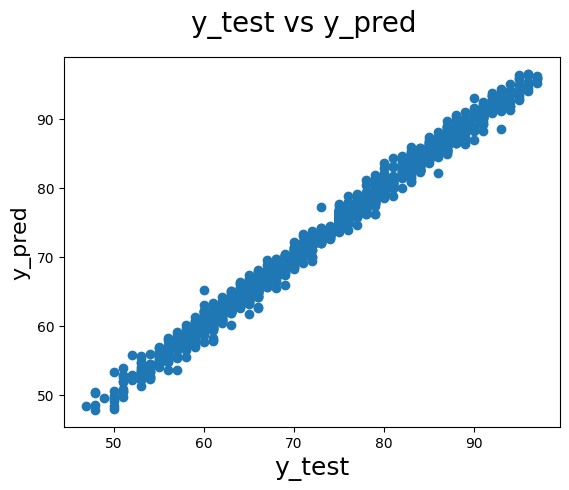

In [34]:
%%time
xgboost_rating(df)